## DSCI 100 Group Project Proposal (UCI Machine Learning Repository Adult Dataset)

<em> Edward Huang, Jonathan Lee, Ryan Gao </em>




## Introduction

There are numerous factors that could affect the amount of money an individual makes. This project aims to predict whether an individual will earn >50k or <=50k a year. We are using the “Adult Data Set” from UCI Machine Learning Repository which contains data on socioeconomic factors such as education, age, and sex, among others (explained below). These factors will serve as predictors in this analysis. This data is from a census conducted in 1994.

Question: Given a set of data pertaining to an individual, will their income be >50k or <=50k?

## Preliminary Exploratory Data Analysis

In [21]:
# Libraries are loaded into R
library(tidyverse)
library(ggplot2)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)

In [22]:
# Data is read and column names are assigned
data <- read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data')
colnames(data) <- c('age', 'workclass', 'fnlwgt', 'education', 
                     'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 
                     'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income')
data

Parsed with column specification:
cols(
  `39` = col_double(),
  `State-gov` = col_character(),
  `77516` = col_double(),
  Bachelors = col_character(),
  `13` = col_double(),
  `Never-married` = col_character(),
  `Adm-clerical` = col_character(),
  `Not-in-family` = col_character(),
  White = col_character(),
  Male = col_character(),
  `2174` = col_double(),
  `0` = col_double(),
  `40` = col_double(),
  `United-States` = col_character(),
  `<=50K` = col_character()
)



age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


### Variable Explanations:

`fnlwgt`: assigns similar weights to units with similar characteristics, as estimated by the census 

`capital_gain` and `capital_loss`: income generated outside of salary 

`education_num`: continuous description of `education` 

The data is already tidy, as each variable is in its own column, each observation is in its own row, and each cell has one data point. 

### Excluded Variables: 

`fnlwgt` has no predictive capability 

`education` and `marital_status` are represented by other variables 

`capital_gain` and `capital_loss` combined into `total_capital`

We found that the most important variables to include were the individual’s work experience and the total education they received (Salary.com, Northern Birch Credit Union), which are best represented by the columns `age` and `education_num`, respectively. Another important variable to consider is the column `hours_per_week`, which represents the total hours the individual spends on their occupation. Finally, as income inequality is still a prevalent issue, we wanted to see the effect of `race` and `sex` as a predictor as well.

In [23]:
# Changing capital_gain and capita_loss into total_capital, and removing irrelevant predictors
data_select <- data %>%
mutate(total_capital = capital_gain - capital_loss) %>%
select(-education, -fnlwgt, -marital_status, -capital_gain, -capital_loss)

# Changing data type of some predictors to factor 
data_new <- mutate(data_select, workclass = as.factor(workclass),
                   occupation = as.factor(occupation),
                   relationship = as.factor(relationship),
                   race = as.factor(race),
                   sex = as.factor(sex),
                   native_country = as.factor(native_country),
                   income = as.factor(income))
data_new

age,workclass,education_num,occupation,relationship,race,sex,hours_per_week,native_country,income,total_capital
<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>
50,Self-emp-not-inc,13,Exec-managerial,Husband,White,Male,13,United-States,<=50K,0
38,Private,9,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K,0
53,Private,7,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
58,Private,9,Adm-clerical,Unmarried,White,Female,40,United-States,<=50K,0
22,Private,9,Adm-clerical,Own-child,White,Male,20,United-States,<=50K,0
52,Self-emp-inc,9,Exec-managerial,Wife,White,Female,40,United-States,>50K,15024


In [24]:
# We can use the function below to identify whether there are NA's in our dataset
sum(is.na(data_new))

[1] 0

In [25]:
# Split the data into a training set and a testing set, with 75% of the data going into the former
data_split <- initial_split(data_new, prop = 0.75, strata = income)
data_train <- training(data_split)
data_test <- testing(data_split)

In [26]:
# Tibble for individuals making >50K
over_50 <- data_train %>%
filter(income == ">50K") %>%
group_by(income) %>%
summarize(high_education = mean(education_num, na.rm = TRUE),
          high_age = mean(age, na.rm = TRUE),
          high_hours = mean(hours_per_week, na.rm = TRUE))
over_50

# Tibble for individuals making <=50K
under_50 <- data_train %>%
filter(income == "<=50K") %>%
group_by(income) %>%
summarize(low_education = mean(education_num, na.rm = TRUE),
          low_age = mean(age, na.rm = TRUE),
          low_hours = mean(hours_per_week, na.rm = TRUE))
under_50

`summarise()` ungrouping output (override with `.groups` argument)



income,high_education,high_age,high_hours
<fct>,<dbl>,<dbl>,<dbl>
>50K,11.63033,44.23976,45.40316


`summarise()` ungrouping output (override with `.groups` argument)



income,low_education,low_age,low_hours
<fct>,<dbl>,<dbl>,<dbl>
<=50K,9.598652,36.79471,38.86537


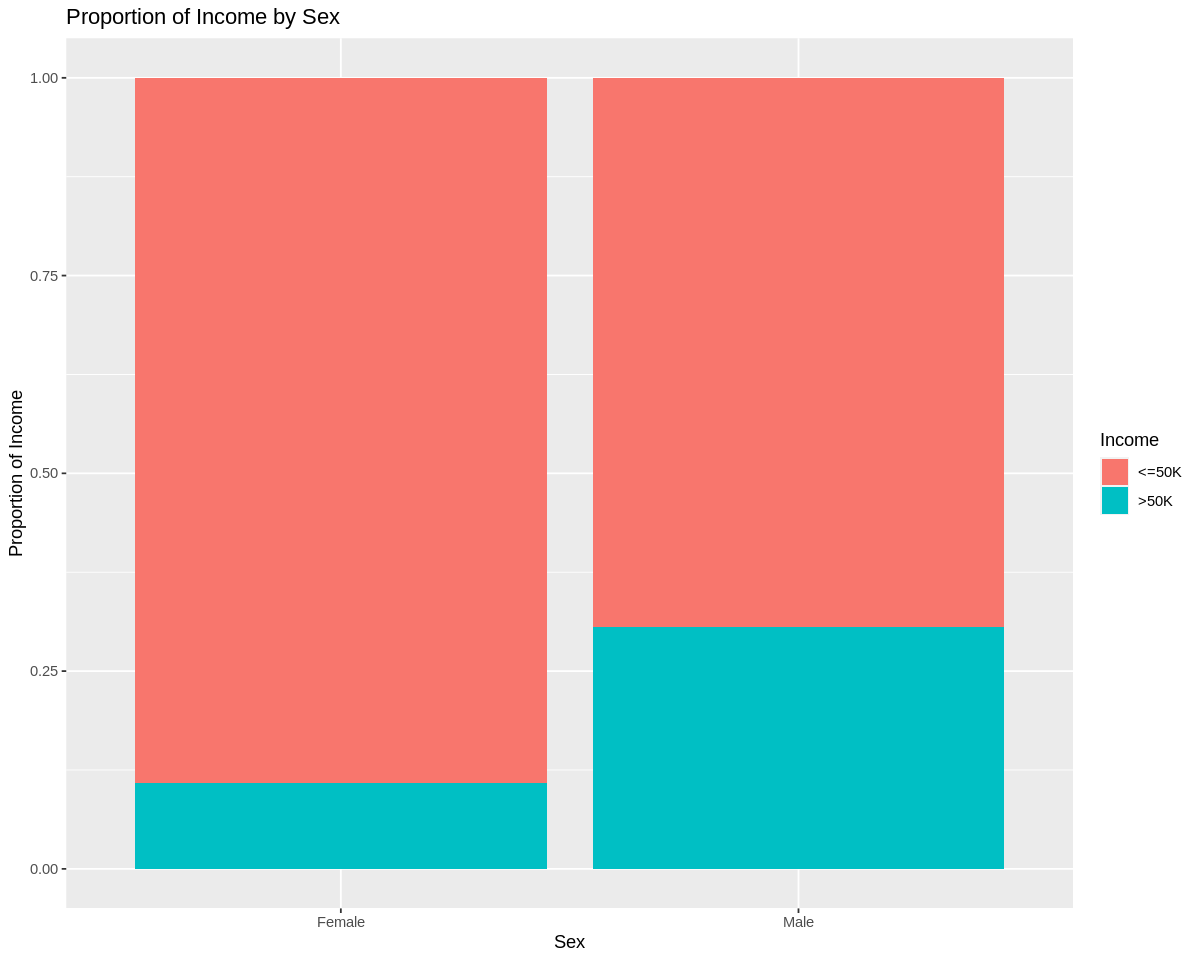

In [27]:
# Proportion of income by sex
gender_proportion_plot <- data_train %>%
    ggplot(aes(x = sex, fill = income)) +
    geom_bar(position = "fill") +
    xlab("Sex") +
    ylab("Proportion of Income") +
    labs(fill = "Income") +
    ggtitle("Proportion of Income by Sex")
gender_proportion_plot


`summarise()` ungrouping output (override with `.groups` argument)



race,n
<fct>,<int>
Amer-Indian-Eskimo,228
Asian-Pac-Islander,781
Black,2364
Other,210
White,20838


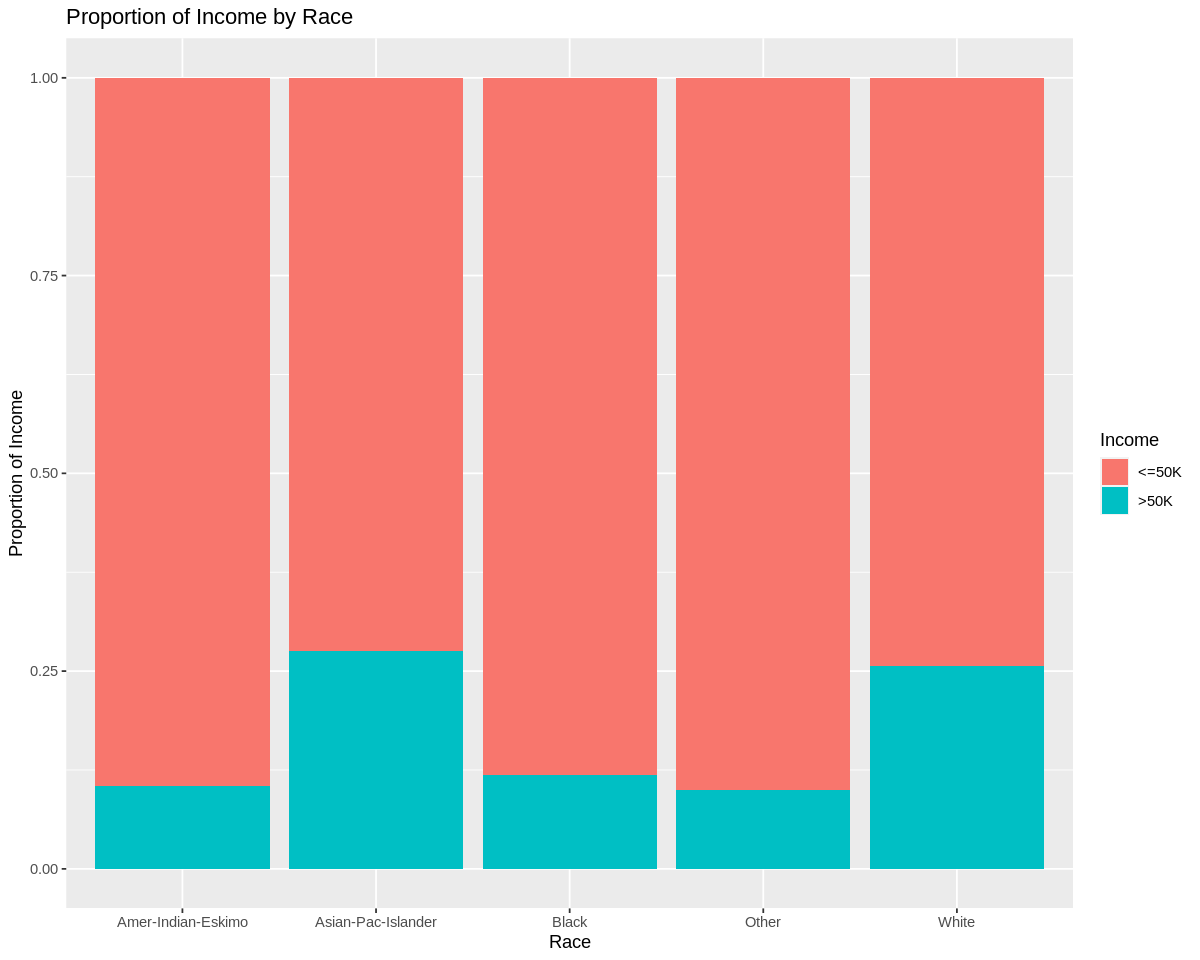

In [28]:
# Number of each race surveyed
options(repr.plot.width = 10, repr.plot.height = 8)
race_counts <- data_train %>%
    group_by(race) %>%
    summarize(n = n())
race_counts

# Proportion of income by race
race_proportion_plot <- data_train %>%
    ggplot(aes(x = race, fill = income)) +
    geom_bar(position = "fill") +
    xlab("Race") +
    ylab("Proportion of Income") +
    labs(fill = "Income") +
    ggtitle("Proportion of Income by Race")
race_proportion_plot


## Method

Since the predictions that we want are based on categorical variables, we will use the K-nearest neighbour classification algorithm.

We first split the data into a training and testing set, which is important when evaluating the trustworthiness of the model. Furthermore, we must also preprocess the data such that it is all standardized. It is important to do this only for the training set as we do not want our testing data to have any impact on how the model is trained.

Then, the classifier will be tuned and a 5-fold cross validation, which determines the most accurate value for K such that no overfitting or underfitting occurs. With this K value, predictions can then be made using the algorithm.

One way that we can visualize the results would be to have stacked bar graphs with the x-axis being a given predictor and the y-axis being the proportion of people with an income level of >50K or <=50K. This is because there are more than two predictors, and 3-D visualizations are not effective for this type.

The predictors that we are planning on using are `education_num`, `age`, `hours_per_week`, `race` and `sex` (mentioned above).

## Expected Outcomes and Significance

Given data corresponding to the predetermined predictors, we expect that our classification model can generate an accurate prediction: whether a person makes over or under 50K. 

The impact of such findings has real world applications. For instance, if it was found that most people with an `education_num` above a certain value made >50K a year, a positive correlation can be determined. From this, a government could choose to increase funding to the education sector to promote economic growth. Conversely, if it was found that most people above a certain age made <=50K year, governments and companies could make adjustments to pension plans or retirement plans to support the older generation, among other things. We can take this further by analyzing some of the predictors themselves, particularly `race` and `sex`, to view the relationship between race and gender, and wealth disparity in order to observe inequality in society.

Sources: 

https://www.salary.com/articles/eight-factors-that-can-affect-your-pay/

https://blog.northernbirchcu.com/2017/01/06/income-essentials-what-factors-effect-your-income/